In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import gif2numpy

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
%matplotlib inline
import splitfolders

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

from tensorflow import keras
from keras.metrics import Accuracy, Precision, Recall

from tensorflow.keras.applications.inception_v3 import InceptionV3

import re

from datetime import date,datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# Processing and loading metadata

In [2]:
#Extracting relevant rows
meta_data = pd.read_csv('final_combined_dataset.csv')

In [3]:
#using the processing functions previously defined
def url(df):
    df["has_url"] = ~df["url"].isna()
    return df

def username(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["un_no_of_char"] = df["username"].apply(lambda x: len(str(x)))
    df["un_special_char"] = df["username"].apply(lambda x: special_char.search(str(x)) != None)
    return df

def name(df):
    special_char = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    df["name_no_of_char"] = df["name"].apply(lambda x: len(str(x)))
    df["name_special_char"] = df["name"].apply(lambda x: special_char.search(str(x)) != None)
    return df

def description(df):
    user_tags = r'\B@\w*[a-zA-Z]*\w*'
    hashtags = r'\B#\w*[a-zA-Z]+\w*'
    links = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
    df["des_no_of_usertags"] = df["description"].apply(lambda x: len(re.findall(user_tags, str(x)))) #str(x).count('@'))
    df["des_no_of_hashtags"] = df["description"].apply(lambda x: len(re.findall(hashtags, str(x)))) #str(x).count('#'))
    df["des_external_links"] = df["description"].apply(lambda x: re.findall(links, str(x)) != [])
    df["has_description"] = ~df["description"].isna() 
    return df

def location(df):
    df["location"] = ~df["location"].isna() # false = location is NaN; true = has location
    return df
  
def time(df):
    # df["created_time"] = df["created_at"].apply(lambda x : datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').date())
    # d1 = date(2022, 10, 8) # date we extracted these data 
    df["account_age_in_days"] = df["created_at"].apply(lambda x : (date(2022, 10, 8) - datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z').date()).days)
    df["average_tweets_per_day"] = df["tweet_count"]/df["account_age_in_days"]
    return df

def follow_count(df):
    df["followers_following_count"] = df["followers_count"] * df["following_count"]
    return df

def account_type(df):
    df["isBot"] = df["account_type"].apply(lambda x : 1 if x == 'bot' else 0)
    return df

def convert_PV(variable):
    if variable == 'True':
        return True
    if variable == 'False':
        return False
    if variable == '0.0':
        return False
    if variable == '1.0':
        return True
    return variable

def convert_TF(variable):
    var = 1 if variable == True else 0
    return var

In [4]:
meta_data = account_type(meta_data)
meta_data = username(meta_data)
meta_data = name(meta_data)
meta_data = description(meta_data)
meta_data = location(meta_data)
meta_data = url(meta_data)
meta_data = time(meta_data)
meta_data = follow_count(meta_data)

pv_var = ["verified", "protected"]

for var in pv_var:
    meta_data[var] = meta_data[var].apply(convert_PV)

boolean_var = ["verified", "location", "un_special_char", 
               "name_special_char", "des_external_links", 
               "has_description", "protected", 
               "has_url", "has_profile_image"]

for var in boolean_var:
    meta_data[var] = meta_data[var].apply(convert_TF)
    
int_var = ["followers_count", "following_count", "tweet_count", "listed_count"]

for var in int_var:
    meta_data[var] = meta_data[var].astype(int)

In [5]:
processed_metadata = meta_data.drop(columns=["Unnamed: 0", "url", "created_at", "name", "username", "description", "profile_image_url", "account_type"])

# Loading the image arrays

In [6]:
# split into training and testing sets 
# splitfolders.ratio("./pictures2", output="images_split", ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

In [7]:
IMG_WIDTH = 200
IMG_HEIGHT = 200

def create_dataset(img_folder, bot=True):
    img_data_array = []
    class_name = []
    image_paths = []
    
    for dir1 in os.listdir(img_folder):
        image_path = os.path.join(img_folder, dir1)
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image_paths.append(image_path)
        try:
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
        except:
            image = gif2numpy.convert(image_path)[0][0]
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data_array.append(image)
        if bot:
            class_name.append([1])
        else: 
            class_name.append([0])
    return img_data_array, class_name, image_paths

# extract the image array and class name
bot_train, class_name_bot, bot_image_paths = create_dataset('./images_split/train/1_bot')
human_train, class_name_human, human_image_paths = create_dataset('./images_split/train/0_human', False)

bot_test, class_name_bot_test, bot_test_paths = create_dataset('./images_split/test/1_bot')
human_test, class_name_human_test, human_test_paths = create_dataset('./images_split/test/0_human', False)

In [8]:
print(len(bot_train))
print(len(class_name_bot))
print(len(human_train))
print(len(class_name_human))

3300
3300
4880
4880


In [9]:
#In this cell, we define functions to process the file names and convert them to ids in order to extract the relevant
#rows from the metadata set.
def bot_name_process(text):
    text = text.replace("./images_split/train/1_bot\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account


def human_name_process(text):
    text = text.replace("./images_split/train/0_human\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account

def val_human_name_process(text):
    text = text.replace("./images_split\\val\\0_human\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account

def val_bot_name_process(text):
    text = text.replace("./images_split\\val\\1_bot\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)

    

def test_bot_name_process(text):
    text = text.replace("./images_split/test/1_bot\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account


def test_human_name_process(text):
    text = text.replace("./images_split/test/0_human\\", "")
    text = text.replace(".jpeg", "")
    text = text.replace(".png", "")
    text = text.replace(".jpg", "")
    text = text.replace(".gif", "")
    
    text_lst = text.split(".")
    text = text_lst[0]
    
    id_account = int(text)
    
    
    return id_account


In [10]:
#extracting the relevant ids to filter the metadata dataframe later

#training set rows
training_bot_ids = list(map(bot_name_process, bot_image_paths))

training_human_ids = list(map(human_name_process, human_image_paths))

test_bot_ids = list(map(test_bot_name_process, bot_test_paths))

test_human_ids = list(map(test_human_name_process, human_test_paths))

In [11]:
#getting the images in array form
bot_train = np.array(bot_train, dtype=np.float32)
human_train = np.array(human_train, dtype=np.float32)
train_images = np.concatenate((bot_train, human_train), dtype=np.float32)
train_labels = np.array(class_name_bot+class_name_human, np.float32)

bot_test = np.array(bot_test, dtype=np.float32)
human_test = np.array(human_test, dtype=np.float32)
test_images = np.concatenate((bot_test, human_test), dtype=np.float32)
test_labels = np.array(class_name_bot_test+class_name_human_test, np.float32)

In [12]:
print(human_train.shape)

(4880, 200, 200, 3)


In [13]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(8180, 200, 200, 3)
(8180, 1)
(1024, 200, 200, 3)
(1024, 1)


# Extracting relevant rows of metadata 
In this section, we shall extract the relevant rows of the metadata and preprocess them for the multi channel neural net.

In [14]:
#Extracting relevant rows of the metadata

#training data
training_metadata = processed_metadata[processed_metadata.id.isin(training_bot_ids + training_human_ids)] 

#testing data
testing_metadata = processed_metadata[processed_metadata.id.isin(test_bot_ids + test_human_ids)]





In [15]:
#ensuring that the order in both training and testing match the order in the image array (ie ensuring that the profile image
#matches to the corresponding metadata) For this, we will have to assign the ids to a dictionary that the value corresponds to
#its index

training_ids = training_bot_ids + training_human_ids

ordered_dict_train = {k:v for k,v in enumerate(training_ids)}

sorting_dict_train = {v:k for k,v in enumerate(training_ids)}

testing_ids = test_bot_ids + test_human_ids

ordered_dict_test = {k:v for k,v in enumerate(testing_ids)}

sorting_dict_test = {v:k for k,v in enumerate(testing_ids)}

In [16]:
#Ordering the respective dataframes in the correct order

training_metadata.sort_values(by = 'id', key = lambda x: x.map(sorting_dict_train), inplace = True)

In [17]:
testing_metadata.sort_values(by = 'id', key = lambda x: x.map(sorting_dict_test), inplace = True)

In [18]:
#Preprocessing the dataframe
training_metadata

,id,protected,verified,location,followers_count,following_count,tweet_count,listed_count,has_profile_image,isBot,...,name_no_of_char,name_special_char,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,has_url,account_age_in_days,average_tweets_per_day,followers_following_count
6386,1021573561,0,0,1,177,159,1577,4,1,1,...,16,0,0,0,0,1,1,3580,0.440503,28143
7730,1022420287,0,0,0,17742,11883,5544,89,1,1,...,18,0,0,0,0,1,0,3580,1.548603,210828186
16034,1024955420,0,0,0,52,222,7261,1,1,1,...,17,0,0,0,0,0,0,3579,2.028779,11544
3985,1070386470,0,0,1,7796,1,12028,27,1,1,...,18,0,0,0,0,1,0,3560,3.378652,7796
18089,1071014605,0,0,1,4325,4812,4176,7,1,1,...,14,0,0,0,0,1,0,3560,1.173034,20811900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4416,9895182,0,0,1,519,127,10674,10,1,0,...,12,0,1,2,0,1,1,5454,1.957096,65913
18708,9981032,0,0,1,183,198,2017,2,1,0,...,12,0,0,0,0,1,1,5451,0.370024,36234
2347,9982862,0,0,1,394,627,12453,10,1,0,...,13,0,0,0,0,1,1,5450,2.284954,247038
919,9988572,1,0,1,1106,1306,10093,27,1,0,...,14,0,0,0,0,1,1,5450,1.851927,1444436


In [19]:
#We can now drop the id column
training_metadata.drop('id', axis = 1, inplace = True)

In [20]:
testing_metadata.drop('id', axis = 1, inplace = True)

In [21]:
scaler = StandardScaler()
numeric_variables = ['followers_count', 'following_count', 'listed_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']

In [22]:
training_metadata[numeric_variables] = scaler.fit_transform(training_metadata[numeric_variables])

testing_metadata[numeric_variables] = scaler.transform(testing_metadata[numeric_variables])

In [23]:
X_train = training_metadata.loc[:,training_metadata.columns != 'isBot']
y_train = training_metadata[['isBot']]

X_test = testing_metadata.loc[:, testing_metadata.columns != 'isBot']
y_test = testing_metadata[['isBot']]

In [24]:
# import the InceptionV3 model  
pre_trained_model = InceptionV3(input_shape = (200, 200, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

# freeze layers
for layer in pre_trained_model.layers:
    layer.trainable = False

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.959):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [25]:
# flatten the output layer to 1 dimension
flat = layers.Flatten()(pre_trained_model.output)

# add a fully connected layer with 2048 hidden units and ReLU activation
dense1 = layers.Dense(2048, activation='relu')(flat)

# add a fully connected layer with 1,024 hidden units and ReLU activation
dense2 = layers.Dense(1024, activation='tanh')(dense1)

# add a fully connected layer with 256 hidden units and ReLU activation
dense3 = layers.Dense(256, activation='relu')(dense2)

#add a dense layer which would be concatenated with the metadata information
dense4 = layers.Dense(16, activation='relu')(dense3)

input_metadata = layers.Input(shape = (20,))

combined = layers.concatenate([input_metadata, dense4])

#add 2 more dense layers to complete the training
dense5 = layers.Dense(128, activation = 'relu')(combined)

dense6 = layers.Dense(64, activation = 'relu')(dense5)

# add a final sigmoid layer for classification
output = layers.Dense(1, activation='sigmoid')(dense6)           

model = Model(inputs = [pre_trained_model.input, input_metadata], outputs = [output]) 


metrics = [
    #keras.metrics.Accuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]


model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc', metrics])

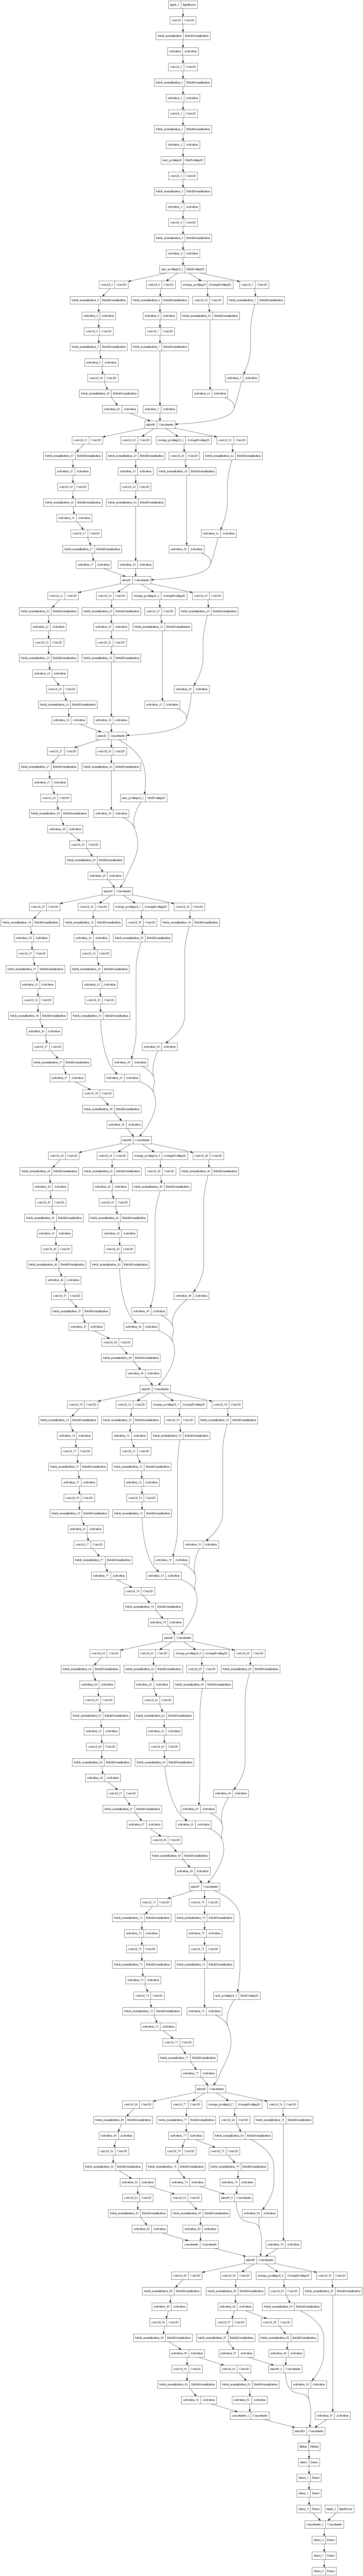

In [26]:
plot_model(model)

In [27]:

#Before training our model, we shall shuffle the training data

train_images, train_labels, X_train = shuffle(train_images, train_labels, X_train)


In [28]:
history = model.fit(
            x = [train_images, X_train],
            y = train_labels,
            #steps_per_epoch = 100,
            epochs = 20,
            #validation_steps = 50,
            verbose = 2)

Epoch 1/20
256/256 - 439s - loss: 45426.6289 - acc: 0.7347 - precision: 0.7592 - recall: 0.5015 - 439s/epoch - 2s/step
Epoch 2/20
256/256 - 492s - loss: 20732.2578 - acc: 0.7540 - precision: 0.7410 - recall: 0.6000 - 492s/epoch - 2s/step
Epoch 3/20
256/256 - 502s - loss: 114411.9531 - acc: 0.7446 - precision: 0.7198 - recall: 0.6009 - 502s/epoch - 2s/step
Epoch 4/20
256/256 - 461s - loss: 206106.8906 - acc: 0.7944 - precision: 0.8759 - recall: 0.5712 - 461s/epoch - 2s/step
Epoch 5/20
256/256 - 451s - loss: 170057.3281 - acc: 0.8079 - precision: 0.8324 - recall: 0.6561 - 451s/epoch - 2s/step
Epoch 6/20
256/256 - 435s - loss: 71650.9531 - acc: 0.8782 - precision: 0.8967 - recall: 0.7891 - 435s/epoch - 2s/step
Epoch 7/20
256/256 - 452s - loss: 234671.2812 - acc: 0.7648 - precision: 0.7034 - recall: 0.7209 - 452s/epoch - 2s/step
Epoch 8/20
256/256 - 444s - loss: 21496.3945 - acc: 0.8068 - precision: 0.7769 - recall: 0.7312 - 444s/epoch - 2s/step
Epoch 9/20
256/256 - 448s - loss: 39291.5117

In [29]:
model.evaluate(x = [test_images, X_test], y = y_test)

32/32 [==============================] - 59s 2s/step - loss: 1781.1968 - acc: 0.9492 - precision: 1.0000 - recall: 0.8741


[1781.19677734375, 0.94921875, 1.0, 0.8740919828414917]

In [30]:
y_pred = model.predict(x = [test_images, X_test])

32/32 [==============================] - 59s 2s/step


In [31]:
y_pred_labels = np.where(y_pred > 0.5, 1,0)

In [33]:
report = classification_report(y_test, y_pred_labels)
roc_auc = roc_auc_score(y_test, y_pred_labels)

print(f'ROC AUC: {roc_auc}')
print(f'Classification Report: \n {report}')

ROC AUC: 0.937046004842615
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       611
           1       1.00      0.87      0.93       413

    accuracy                           0.95      1024
   macro avg       0.96      0.94      0.95      1024
weighted avg       0.95      0.95      0.95      1024

